In [42]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import draw
import skimage.io as io
import glob
import os
from Motion_blur import Motion_blur, Motion_blur_kernel

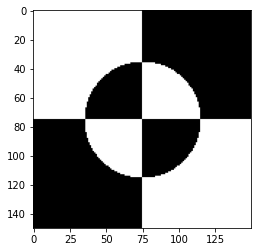

In [43]:
def Test_img():
    Timg = np.zeros((150,150))
    Timg[0:75,0:75] = 255
    Timg[75:,75:] = 255

    radius = 40
    ri, ci = draw.disk((75,75), radius=radius, shape=Timg.shape)
    Timg[ri, ci] -=255
    Timg = np.abs(Timg)
    #Timg[ri, ci] -= 123
    #Timg = np.clip(Timg, 0, 255)
    return Timg

Timg = Test_img()
plt.imshow(Timg, cmap='gray')

In [44]:
# Creating the Red Image
zero_img = np.zeros((150,150))

Timg2 = np.stack((Timg,zero_img,zero_img), axis=2).astype('uint8')
io.imsave('Test_Img/R.png', Timg2)
#plt.imshow(Timg2)

In [45]:
# Creating RGB image
Timg_rot = np.rot90(Timg)
Timg_blank = np.zeros((150,150))

In [46]:
R = np.concatenate((Timg,Timg,Timg_blank),axis=1)
G = np.concatenate((Timg_blank,Timg_rot,Timg_rot),axis=1)
B = np.concatenate((Timg_rot, Timg_blank, Timg), axis = 1)

RGB = np.stack((R,G,B), axis=2).astype('uint8')
io.imsave('Test_Img/RGB.png', RGB)
#plt.imshow(RGB)

In [47]:
out = 'Test_Img/'
T = np.stack([Timg,Timg,Timg], axis=2).astype('uint8')
io.imsave('Test_Img/BW.png', T)

# Create Blurred Images

In [48]:
def non_uniform_blur(img, L, A):
    M, N, C = img.shape
    Out = np.zeros((M,N,C))
    
    for i in range(0,M):
        for j in range(0,N):

            #Create Kernel
            Kernel, tmp1, tmp2 = Motion_blur_kernel(L[i,j], A[i,j])
            mi, ni = Kernel.shape

            #Center kernel pixel
            ckm = mi // 2
            ckn = ni // 2


            #Get image patch range the range changes depending if the side of kernel is odd or even
            if mi % 2 == 0: #Even side
                Starti = i - ckm
                Endi = i + ckm
            else: #odd side
                Starti = i - ckm
                Endi = i + ckm + 1

            if ni % 2 == 0: 
                Startj = j - ckn
                Endj = j + ckn
            else:
                Startj = j - ckn
                Endj = j + ckn + 1

            if Starti >= 0 and Endi <= M and Startj >= 0 and Endj <= N:
                try:
                    Ipatch = img[Starti:Endi,Startj:Endj,:]

                    Out[i,j,0] = np.sum(Ipatch[:,:,0] * Kernel)
                    Out[i,j,1] = np.sum(Ipatch[:,:,1] * Kernel)
                    Out[i,j,2] = np.sum(Ipatch[:,:,2] * Kernel)
                except:
                    print(i,j, Ipatch.size, Kernel.size)

            #If the kernel is out of bounds from the sharp image then we recalculate bounds to crop kernel 
            #to match the image of interest
            else:
                #Initialize Kernel range
                K_Starti = 0
                K_Startj = 0
                K_Endi = mi
                K_Endj = ni

                #Start if logic to recalculate new bounds
                #print(Starti, Startj, Endi, Endj, mi, ni)
                if Starti < 0:
                    K_Starti = np.abs(Starti)
                    Starti = 0

                if Startj < 0:
                    K_Startj = np.abs(Startj)
                    Startj = 0

                if Endi > M:
                    K_Endi = mi - (Endi - M)
                    Endi = M

                if Endj > N:
                    K_Endj = ni - (Endj - N)
                    Endj = N

                #Crop the new area of interest
                try:
                    Ipatch = img[Starti:Endi,Startj:Endj,:]
                    Crop_Kernel = Kernel[K_Starti:K_Endi,K_Startj:K_Endj]

                    Out[i,j,0] = np.sum(Ipatch[:,:,0] * Crop_Kernel)
                    Out[i,j,1] = np.sum(Ipatch[:,:,1] * Crop_Kernel)
                    Out[i,j,2] = np.sum(Ipatch[:,:,2] * Crop_Kernel)
                except:
                    print(i,j, Ipatch.shape, Crop_Kernel.shape, K_Starti, K_Endi, K_Startj, K_Endj)
                    
    return Out.astype('uint8')

In [49]:
def blur_field_gen(M,N,row,col,values):
    """
    M,N - Shape of overall blur field M-Rows, N-Columns
    row,col - is how many row and column regions to shop the blur field into
    values - a 1-Dimentional array values that scans row by row.
    """

    blur_field = np.zeros((M,N))
    M_step = M//row
    N_step = N//col

    index = 0
    for i in range(0,row):
        for j in range(0,col):
            #print(i*M//row,(i+1)*M//row,j*N//col,(j+1)*N//col, index)
            blur_field[i*M//row:(i+1)*M//row,j*N//col:(j+1)*N//col] = values[index]

            if index < len(values)-1:
                index += 1

    return blur_field.astype('int')


In [50]:
output_dir = 'TestPattern_Blurs/'


In [51]:
# Grab COCO Image
# Create blur field maps
# Generate non-uniform blur image
# Save to output folder
row = 1
col = 1
avalues = [-45]
lvalues = [15]

filenames = sorted(glob.glob('Test_Img/*'))

for file in filenames:
    sharp = io.imread(file)
    M, N, C = sharp.shape
    
    # Create blur field maps
    Lmap = blur_field_gen(M, N, row, col, lvalues)
    Amap = blur_field_gen(M, N, row, col, avalues)
    
    #generate non-uniform blur iamges
    blur = non_uniform_blur(sharp, Lmap, Amap)
    
    out_name = output_dir+os.path.basename(file).split('.')[0]+'_UB' +'.png'
    io.imsave(out_name,blur)
    #plt.figure()
    #plt.imshow(blur)
    
    
    

In [57]:
# Grab COCO Image
# Create blur field maps
# Generate non-uniform blur image
# Save to output folder
row = 2
col = 1
avalues = [-45,45]
lvalues = [15]

filenames = sorted(glob.glob('Test_Img/*'))

for file in filenames:
    sharp = io.imread(file)
    M, N, C = sharp.shape
    
    # Create blur field maps
    Lmap = blur_field_gen(M, N, row, col, lvalues)
    Amap = blur_field_gen(M, N, row, col, avalues)
    
    #generate non-uniform blur iamges
    blur = non_uniform_blur(sharp, Lmap, Amap)
    
    out_name = output_dir+os.path.basename(file).split('.')[0]+'_NUB_half' +'.png'
    io.imsave(out_name,blur)
    #plt.figure()
    #plt.imshow(blur)
    
    
    

In [58]:
# Grab COCO Image
# Create blur field maps
# Generate non-uniform blur image
# Save to output folder
row = 3
col = 1
avalues = [-45,45,-45]
lvalues = [15]

filenames = sorted(glob.glob('Test_Img/*'))

for file in filenames:
    sharp = io.imread(file)
    M, N, C = sharp.shape
    
    # Create blur field maps
    Lmap = blur_field_gen(M, N, row, col, lvalues)
    Amap = blur_field_gen(M, N, row, col, avalues)
    
    #generate non-uniform blur iamges
    blur = non_uniform_blur(sharp, Lmap, Amap)
    
    out_name = output_dir+os.path.basename(file).split('.')[0]+'_NUB_thirds' +'.png'
    io.imsave(out_name,blur)
    #plt.figure()
    #plt.imshow(blur)
    
    
    

In [60]:
# Grab COCO Image
# Create blur field maps
# Generate non-uniform blur image
# Save to output folder
row = 6
col = 1
avalues = [-45,45,-45,45,-45,45]
lvalues = [15]

filenames = sorted(glob.glob('Test_Img/RGB*'))

for file in filenames:
    sharp = io.imread(file)
    M, N, C = sharp.shape
    
    # Create blur field maps
    Lmap = blur_field_gen(M, N, row, col, lvalues)
    Amap = blur_field_gen(M, N, row, col, avalues)
    
    #generate non-uniform blur iamges
    blur = non_uniform_blur(sharp, Lmap, Amap)
    
    out_name = output_dir+os.path.basename(file).split('.')[0]+'_NUB_sixths' +'.png'
    io.imsave(out_name,blur)
    #plt.figure()
    #plt.imshow(blur)
    
    
    